<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/fluidflow/gaspipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculation of pressure drop in gas pipelines

This notebook is part of [introduction to natural gas processing using NeqSim](https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/examples_of_NeqSim_in_Colab.ipynb).

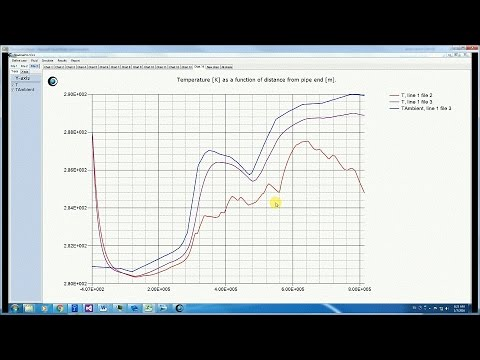

In [1]:
#@title Introduction to Calculation of pressure drop in gas pipelines
#@markdown Calculation of pressure drop in gas pipelines
from IPython.display import YouTubeVideo
YouTubeVideo('C4mq8QlOOsQ', width=600, height=400)

# Initialize use of NeqSim in Python

In [2]:
%%capture
!pip install git+https://github.com/equinor/neqsim-python.git
from neqsim.thermo.thermoTools import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
plt.style.use('classic')
%matplotlib inline

# Demo of a simple NeqSim gas pipeline simulation

In [3]:
from neqsim import methods
from neqsim.thermo import fluid, TPflash, createfluid2
from neqsim.process import pipe, pipeline, clearProcess, stream, runProcess

#Creating inlet fluid using SRK-EoS
names = ['CO2', 'nitrogen', 'methane', 'ethane']
molefractions = [0.03, 0.02, 0.85, 0.01]
fluid1 = createfluid2(names, molefractions)

#Creating stream and pipeline
clearProcess()
stream1 = stream(fluid1)
stream1.setFlowRate(60.0, "MSm3/day")
stream1.setTemperature(50.15, "C")
stream1.setPressure(200.0, "bara")

diameter = [0.98, 0.98, 0.98, 0.98, 0.98] #meter
roughnes = [5.0e-6, 5.0e-6, 5.0e-6, 5.0e-6, 5.0e-6] #meter
position = [0.0, 5000.0, 10000.0, 20000.0, 700000.0] #meter
height = [0.0, -400.0, -800.0, -900.0, 0.0] #meter
outtemperatures =[278.15, 278.15, 278.15, 278.15, 278.15] #Kelvin
outHeatU = [25.0, 25.0, 25.0, 25.0, 25.0] #W/m2K
wallHeatU = [35.0, 35.0, 35.0, 35.0, 35.0] #W/m2K

pipe1 = pipeline(stream1, position, diameter, height, outtemperatures, roughnes,outHeatU,wallHeatU)
pipe1.setNumberOfNodesInLeg(50)
runProcess()
numberofnodes = pipe1.getPipe().getTotalNumberOfNodes()
print('outlet pressure ', pipe1.getPipe().getNode(numberofnodes-1).getBulkSystem().getPressure('bara'))
print('outlet temperature ', pipe1.getPipe().getNode(numberofnodes-1).getBulkSystem().getTemperature('C'))

outlet pressure  118.54040866804519
outlet temperature  1.3470426547119132


In [4]:
print('total number of legs ', pipe1.getPipe().getNumberOfLegs())
print('total number of nodes ', pipe1.getPipe().getTotalNumberOfNodes())
print('friction factor ', pipe1.getPipe().getNode(0).getWallFrictionFactor())
print('friction factor ', pipe1.getPipe().getNode(numberofnodes-1).getWallFrictionFactor())

total number of legs  4
total number of nodes  202
friction factor  0.007796657527555743
friction factor  0.0077216588093840695


# Graphical output of pressure and temperature profile of pipeline

Text(0.5, 0, 'position [meter]')

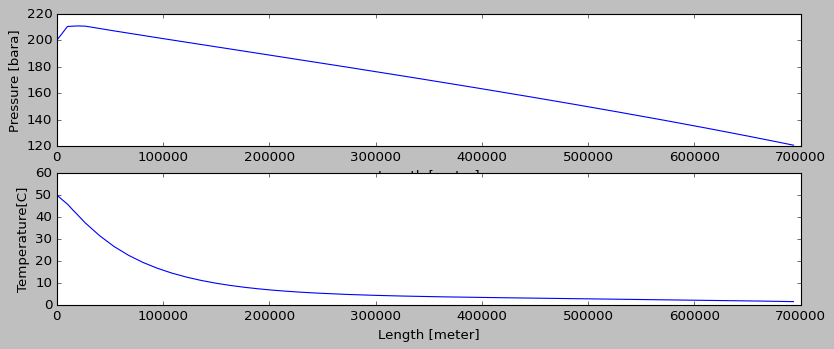

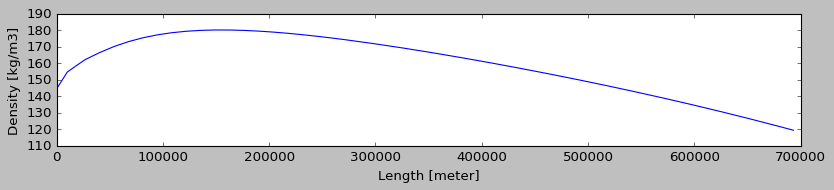

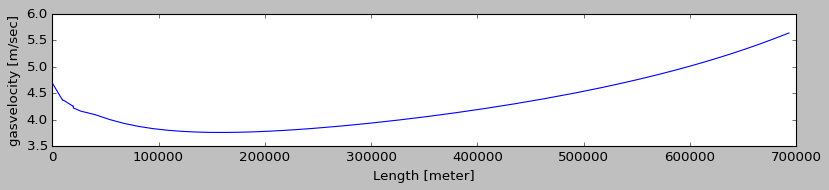

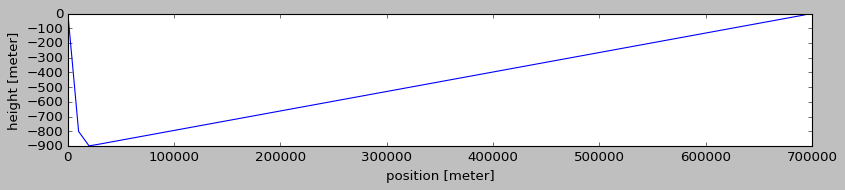

In [5]:
pres = []
temp = []
length = []
height = []
calcdensity = []
gasvelocity = []

for node in range (0,pipe1.getPipe().getTotalNumberOfNodes()-1):
  pres.append(pipe1.getPipe().getNode(node).getBulkSystem().getPressure('bara'))
  temp.append(pipe1.getPipe().getNode(node).getBulkSystem().getTemperature('C'))
  height.append(pipe1.getPipe().getNode(node).getVerticalPositionOfNode())
  length.append(pipe1.getPipe().getNode(node).getDistanceToCenterOfNode())
  calcdensity.append(pipe1.getPipe().getNode(node).getBulkSystem().getDensity('kg/m3'))
  gasvelocity.append(pipe1.getPipe().getNode(node).getVelocity())

plt.rcParams['figure.figsize'] = [12, 12]
plt.figure()
plt.subplot(5, 1, 1)
plt.plot(length, pres, '-')
plt.ylabel('Pressure [bara]')
plt.xlabel('Length [meter]')

plt.subplot(5, 1, 2)
plt.plot(length, temp)
plt.xlabel('Length [meter]')
plt.ylabel('Temperature[C]')

plt.figure()
plt.subplot(5, 1, 3)
plt.plot(length, calcdensity, '-')
plt.ylabel('Density [kg/m3]')
plt.xlabel('Length [meter]')

plt.figure()
plt.subplot(5, 1, 4)
plt.plot(length, gasvelocity, '-')
plt.ylabel('gasvelocity [m/sec]')
plt.xlabel('Length [meter]')

plt.figure()
plt.subplot(5, 1, 5)
plt.plot(length, height, '-')
plt.ylabel('height [meter]')
plt.xlabel('position [meter]')

#Constant friction factor calculation


In [6]:
from neqsim import methods
from neqsim.thermo import fluid, TPflash, createfluid2
from neqsim.process import pipe, pipeline, clearProcess, stream, runProcess

#Creating inlet fluid using SRK-EoS
names = ['CO2', 'nitrogen', 'methane', 'ethane']
molefractions = [0.03, 0.02, 0.85, 0.01]
fluid1 = createfluid2(names, molefractions)

#Creating stream and pipeline
clearProcess()
stream1 = stream(fluid1)
stream1.setFlowRate(60.0, "MSm3/day")
stream1.setTemperature(50.15, "C")
stream1.setPressure(200.0, "bara")
stream1.run()

diameter = [1.1, 1.1, 1.1, 1.1, 1.1] #meter
roughnes = [50.0e-6, 50.0e-6, 50.0e-6, 150.0e-6, 150.0e-6] #meter
position = [0.0, 500.0, 1000.0, 1200.0, 700000.0] #meter
height = [0.0, -400.0, -800.0, -900.0, 0.0] #meter
outtemperatures =[278.15, 278.15, 278.15, 278.15, 278.15] #Kelvin
outHeatU = [25.0, 25.0, 25.0, 25.0, 25.0] #W/m2K
wallHeatU = [35.0, 35.0, 35.0, 35.0, 35.0] #W/m2K

pipe1 = pipeline(stream1, position, diameter, height, outtemperatures, roughnes,outHeatU,wallHeatU)
pipe1.setNumberOfNodesInLeg(50)
pipe1.run()
pipe1.getPipe().solveSteadyState(10)

print('results calculated friction factor: ', pipe1.getPipe().getNode(0).getWallFrictionFactor())
print('outlet pressure ', pipe1.getPipe().getNode(numberofnodes-1).getBulkSystem().getPressure('bara'))
print('outlet temperature ', pipe1.getPipe().getNode(numberofnodes-1).getBulkSystem().getTemperature('C'))

frictionFactor = 0.00725
for i in range(pipe1.getPipe().getTotalNumberOfNodes()-1):
   pipe1.getPipe().getNode(i).setWallFrictionFactor(0, frictionFactor);

pipe1.getPipe().solveSteadyState(10);
print('results specified friction factor: ',  pipe1.getPipe().getNode(0).getWallFrictionFactor())
print('outlet pressure ', pipe1.getPipe().getNode(numberofnodes-1).getBulkSystem().getPressure('bara'))
print('outlet temperature ', pipe1.getPipe().getNode(numberofnodes-1).getBulkSystem().getTemperature('C'))


results calculated friction factor:  0.010489691263036484
outlet pressure  126.15569924681752
outlet temperature  2.3222727444941142
results specified friction factor:  0.00725
outlet pressure  159.95978977012348
outlet temperature  3.9454540430199927


#Grapical output

Text(0.5, 0, 'position [meter]')

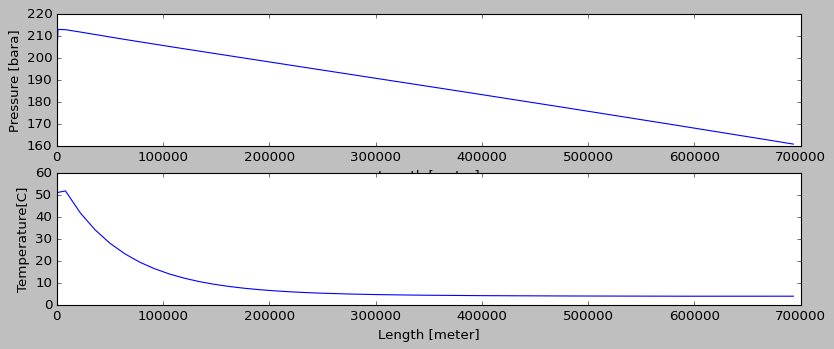

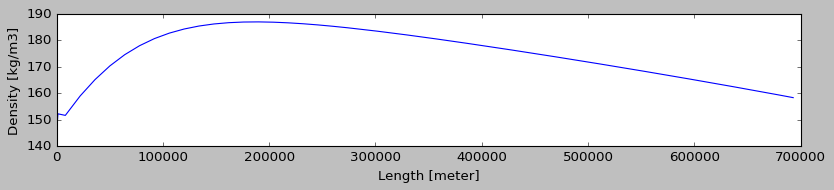

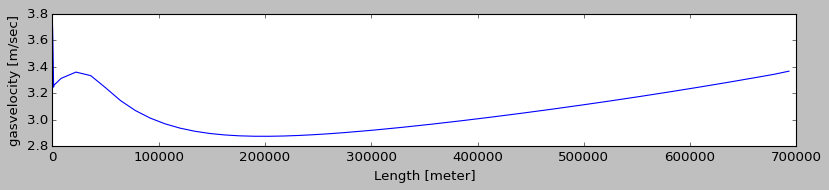

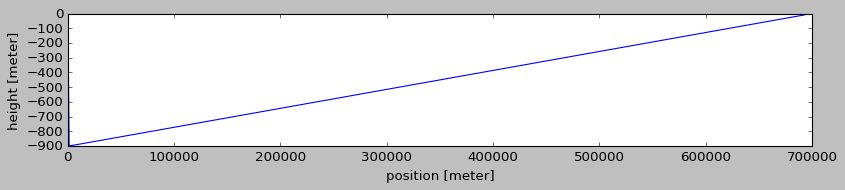

In [7]:
pres = []
temp = []
length = []
height = []
calcdensity = []
gasvelocity = []

for node in range (0,pipe1.getPipe().getTotalNumberOfNodes()-1):
  pres.append(pipe1.getPipe().getNode(node).getBulkSystem().getPressure('bara'))
  temp.append(pipe1.getPipe().getNode(node).getBulkSystem().getTemperature('C'))
  height.append(pipe1.getPipe().getNode(node).getVerticalPositionOfNode())
  length.append(pipe1.getPipe().getNode(node).getDistanceToCenterOfNode())
  calcdensity.append(pipe1.getPipe().getNode(node).getBulkSystem().getDensity('kg/m3'))
  gasvelocity.append(pipe1.getPipe().getNode(node).getVelocity())

plt.rcParams['figure.figsize'] = [12, 12]
plt.figure()
plt.subplot(5, 1, 1)
plt.plot(length, pres, '-')
plt.ylabel('Pressure [bara]')
plt.xlabel('Length [meter]')

plt.subplot(5, 1, 2)
plt.plot(length, temp)
plt.xlabel('Length [meter]')
plt.ylabel('Temperature[C]')

plt.figure()
plt.subplot(5, 1, 3)
plt.plot(length, calcdensity, '-')
plt.ylabel('Density [kg/m3]')
plt.xlabel('Length [meter]')

plt.figure()
plt.subplot(5, 1, 4)
plt.plot(length, gasvelocity, '-')
plt.ylabel('gasvelocity [m/sec]')
plt.xlabel('Length [meter]')

plt.figure()
plt.subplot(5, 1, 5)
plt.plot(length, height, '-')
plt.ylabel('height [meter]')
plt.xlabel('position [meter]')

# Pressure drop calculations based on simplified methods
In the follwing section we use simplified methods for calulating pressure drop in gas pipelines.

In [8]:
insideDiameter = 1.100
length = 1000.0
R = 8.314
inletPressure = 200.0
frictionFactor = 0.0102
area = 3.14*insideDiameter*insideDiameter/4.0
newPres = inletPressure

stream1 = stream(fluid1)
stream1.setFlowRate(60.0, "MSm3/day")
stream1.setTemperature(5.0, "C")

for i in range(700):
  #print('presssure ', newPres)
  stream1.setPressure(newPres, "bara")
  stream1.run()
  stream1.getFluid().initProperties()
  velocity = stream1.getFlowRate('m3/sec') / area
  #print(velocity)
  reynoldsNumber = velocity * insideDiameter/stream1.getFluid().getPhase(0).getPhysicalProperties().getKinematicViscosity()

  #newPres = math.sqrt(math.pow(stream1.getPressure('bara'), 2.0) - math.pow(4.0 * stream1.getFlowRate('m3/sec')/3.14, 2.0) * frictionFactor * length * stream1.getFluid().getPhase(0).getZ() * R * stream1.getFluid().getTemperature()/math.pow(insideDiameter, 5.0)/1.0e5)

  #newPres = math.sqrt(math.pow(stream1.getPressure('bara'), 2.0) - stream1.getFluid().getPhase(0).getZ()*R*stream1.getFluid().getTemperature()*
  #                    math.pow(stream1.getFlowRate('kg/sec')/area, 2.0)*frictionFactor * length/insideDiameter/1.0e5)
  #print(newPres)
  #math.pow(4.0 * stream1.getFlowRate('m3/sec')/3.14, 2.0) * frictionFactor * length * stream1.getFluid().getPhase(0).getZ() * R * stream1.getFluid().getTemperature()/math.pow(insideDiameter, 5.0)/1.0e5)


stream1.getFluid().initProperties()


outletpressure = stream1.getPressure()
print('outlet pressure ',outletpressure)

outlet pressure  200.0


#Estimating inlet pressure based on flow and outlet pressure
In the following example we will use the above method to calculate to inlet pressure based on a known outlet pressure and flow rate.

In [16]:
#Creating inlet fluid using SRK-EoS
names = ['nitrogen', 'CO2', 'methane', 'ethane', 'propane']
molefractions =  [0.01, 0.02, 0.93, 0.03, 0.01]
fluid1 = createfluid2(names, molefractions)
fluid1.setMixingRule('classic')

pipe_wall_roughness = 15e-6 #meter
pipeline_length = 100 #km
pipeline_diameter = 18 #inches
elevation = 0.0 #meter

failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


,flow,in_pressure,out_pressure,velocity
0,1,13.971308,10.0,4.763405
1,1,22.229804,20.0,2.930639
2,1,50.872243,50.0,1.188874
3,1,80.513011,80.0,0.699395
4,1,100.397001,100.0,0.539592
5,1,150.257672,150.0,0.346136
6,1,200.202182,200.0,0.268100
7,2,21.439276,10.0,6.089863
8,2,27.578133,20.0,4.659394
9,2,53.298671,50.0,2.255485


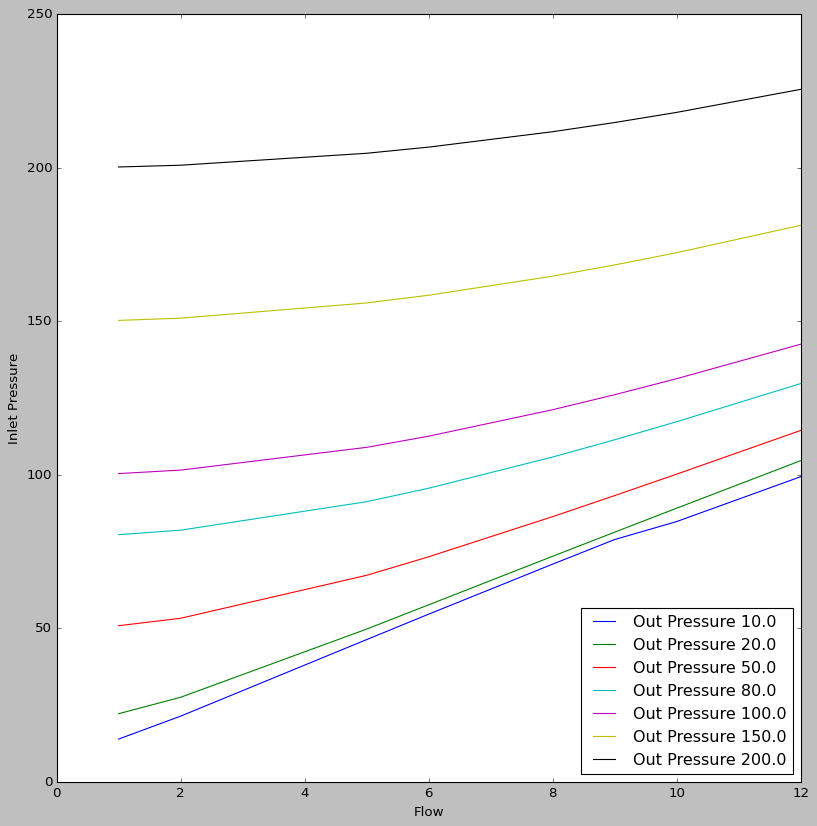

In [17]:
from neqsim import methods
from neqsim.thermo import fluid, TPflash, createfluid2
from neqsim.process import pipe, pipeline, clearProcess, stream, runProcess
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
import random

feed_stream = jNeqSim.processSimulation.processEquipment.stream.Stream(fluid1)
feed_stream.setTemperature(5.0, 'C')
feed_stream.setPressure(100.0, 'bara')
pipeline = jNeqSim.processSimulation.processEquipment.pipeline.PipeBeggsAndBrills(feed_stream)
pipeline.setPipeWallRoughness(pipe_wall_roughness)
pipeline.setLength(pipeline_length*1e3)
pipeline.setElevation(elevation)
pipeline.setDiameter(pipeline_diameter*0.0254)
pipeline.setNumberOfIncrements(10)

def calcinpres(inletpressure, flow, outletpressure):
  feed_stream.setFlowRate(flow, "MSm3/day")
  feed_stream.setPressure(inletpressure, "bara")
  feed_stream.run()
  try:
    pipeline.run()
  except:
    print('failed')
    return 10.0+random.random()
  return pipeline.getOutletStream().getPressure("bara")-outletpressure

data = {'flow': [],  'in_pressure':[], 'out_pressure': [], 'velocity':[] }

#set flow and outlet pressure to calculate inlet pressure
for flows in [1, 2, 5, 6, 8, 9, 10, 12]:
  for outletpres in[10, 20, 50, 80, 100.0,150, 200.0]:
    data['flow'].append(flows);
    data['out_pressure'].append(outletpres);
    inletpres = least_squares(calcinpres, outletpres+flows*20, args=(flows, outletpres), bounds=(5.0, 5000.0));
    if(inletpres.success != True):
      print('failed to solve....')
    data['in_pressure'].append(inletpres.x[0]);
    data['velocity'].append(pipeline.getInletSuperficialVelocity());
    #print('inlet pressure ' ,inletpres.x[0] , ' otlet pressure ', outletpres,  'flow ', flows);


df = pd.DataFrame(data)
filename = 'data-pipeline-'+ str(pipeline_length) + 'km-' + str(pipeline_diameter) + 'in_id.csv'
df.to_csv(filename)

from IPython.display import display
display(df)

grouped = df.groupby('out_pressure')

# Create line plots for each group
fig, ax = plt.subplots()
for name, group in grouped:
    ax.plot(group['flow'],group['in_pressure'], label='Out Pressure {}'.format(name))
ax.set_ylabel('Inlet Pressure')
ax.set_xlabel('Flow')
ax.legend(loc='best')
plt.show()

